In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import torch
import matplotlib.pyplot as plt
from flipper_training.configs import *
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from copy import deepcopy
from collections import deque

In [3]:
from flipper_training.vis.static_vis import *

In [4]:
torch.random.manual_seed(420)

In [27]:
num_robots = 16

In [28]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing='xy')

In [29]:
# gaussian hm
z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
     0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
     2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
     ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1024, 256, 256])

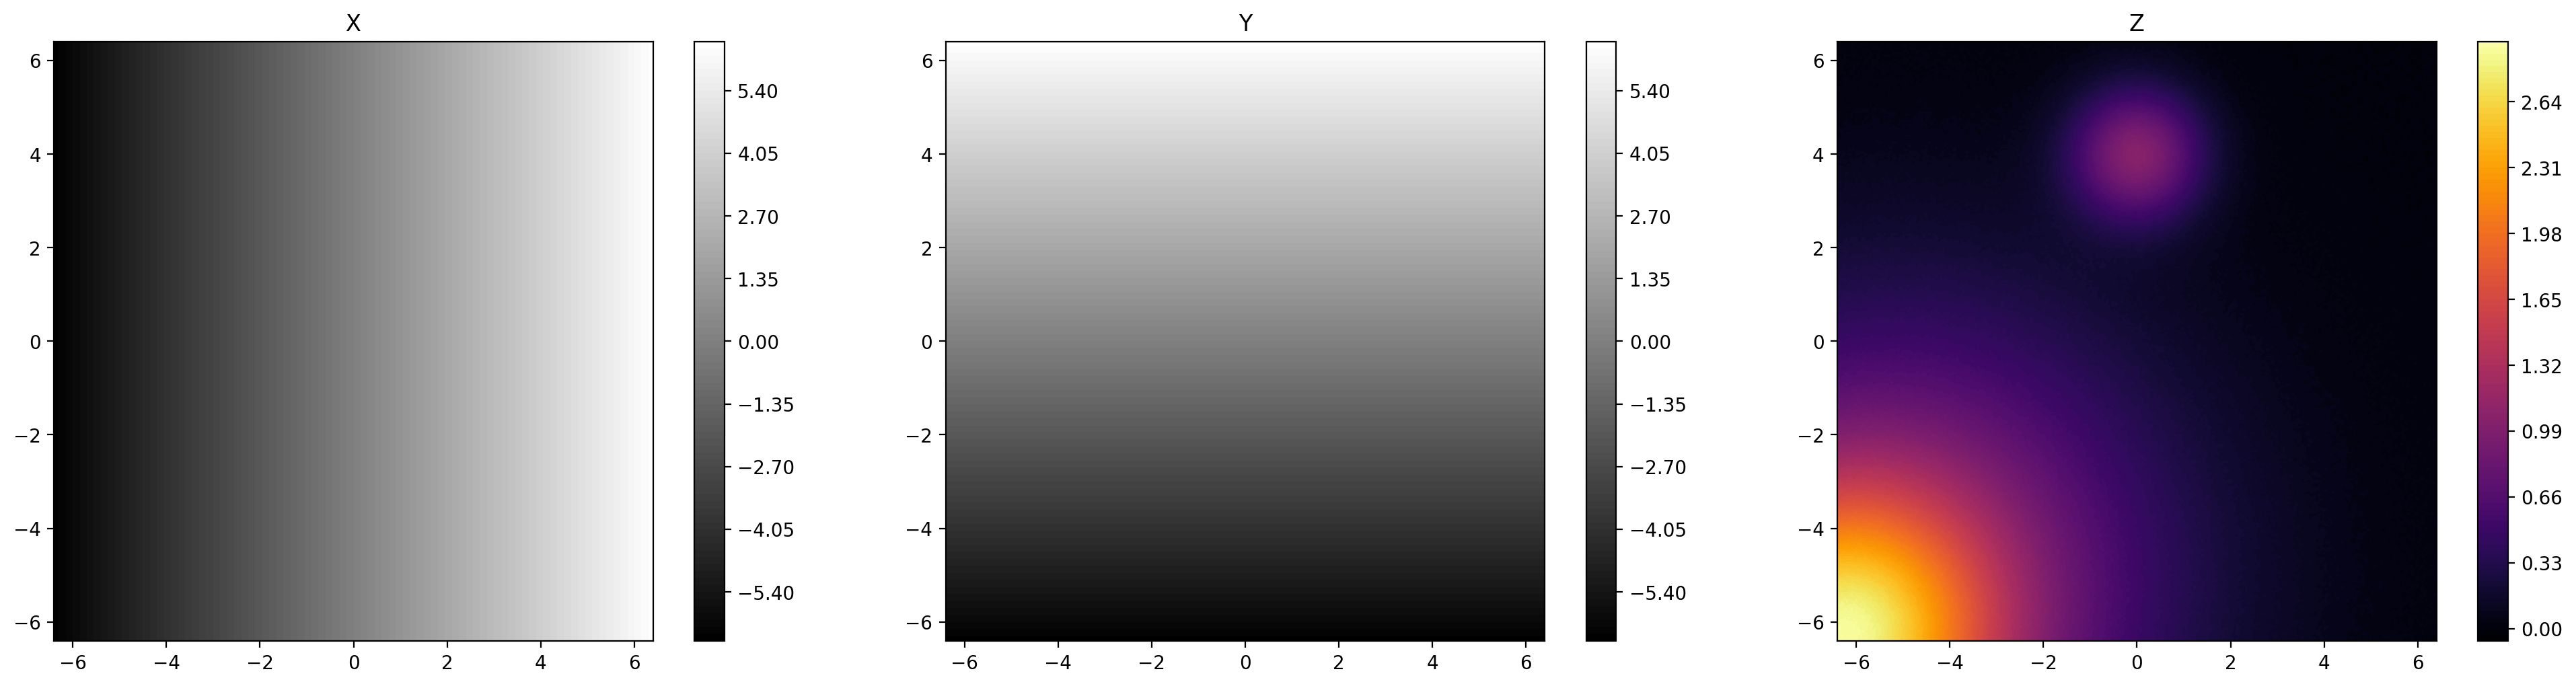

In [30]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [31]:
from flipper_training.utils.torch_utils import autodevice

device = autodevice()

In [32]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", voxel_size=0.08, points_per_driving_part=150)
world_config = WorldConfig(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /mnt/personal/korcadav/flipper_training/.robot_cache/marv_0.080_150.pt


In [33]:
# Controls
traj_length = 15.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = -0.5  # rad/s yaw
controls = robot_model.get_controls(torch.tensor([speed, omega]))
flipper_controls = torch.zeros_like(controls)

In [34]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.move_all_tensors_to_device(device)

In [35]:
engine = DPhysicsEngine(physics_config, robot_model, device)

In [36]:
x0 = torch.tensor([-6, -6, 5.]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
R0 = torch.eye(3).to(device).repeat(num_robots, 1, 1)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, 4).to(device)
local_robot_points0 = robot_model.robot_points.to(device).repeat(num_robots, 1, 1)
controls_all = torch.cat((controls, flipper_controls)).unsqueeze(0).repeat(n_iters, num_robots, 1).to(device)

In [37]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi
periods = 2
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, len(controls)] = rot_vels
controls_all[:, :, len(controls) + 1] = rot_vels
controls_all[:, :, len(controls) + 2] = -rot_vels
controls_all[:, :, len(controls) + 3] = -rot_vels

In [38]:
init_state = PhysicsState(x0, xd0, R0, local_robot_points0, omega0, thetas0)

In [39]:
bench_state = deepcopy(init_state)

In [40]:
compile = True
compile_opts = {"mode": "max-autotune"}

In [41]:
if compile:
    # run all torch compilation
    engine = torch.compile(engine, **compile_opts)
    _ = engine(bench_state, controls_all[0], world_config)

AUTOTUNE bmm(1024x855x3, 1024x3x3)
  triton_bmm_72 0.1034 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=128, BLOCK_N=16, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=3, num_warps=4
  triton_bmm_73 0.1546 ms 66.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=128, BLOCK_N=16, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=4, num_warps=8
  triton_bmm_74 0.1546 ms 66.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=128, BLOCK_N=16, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=2, num_warps=8
  triton_bmm_75 0.1546 ms 66.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=128, BLOCK_N=16, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_bmm_68 0.1577 ms 65.6% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=16, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=4
  triton_bmm_69 0.1577 ms

In [42]:
%%timeit -o
_ = engine(bench_state, controls_all[0],world_config)

299 μs ± 124 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 299 μs ± 124 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [43]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [44]:
%%time 
state = deepcopy(init_state)
i = 0
for ctrl in controls_all:
    state, der, aux = engine(state, ctrl, world_config)
    states.append(deepcopy(state))
    dstates.append(der)
    auxs.append(aux)
    i += 1

CPU times: user 1.93 s, sys: 1.13 s, total: 3.06 s
Wall time: 13.1 s


In [45]:
from flipper_training.engine.engine_state import vectorize_iter_of_tensor_tuples

In [24]:
states_vec = vectorize_iter_of_tensor_tuples(states)
dstates_vec = vectorize_iter_of_tensor_tuples(dstates)
aux_vec = vectorize_iter_of_tensor_tuples(auxs)

<Axes: title={'center': 'Birdview of trajectory'}, xlabel='x', ylabel='y'>

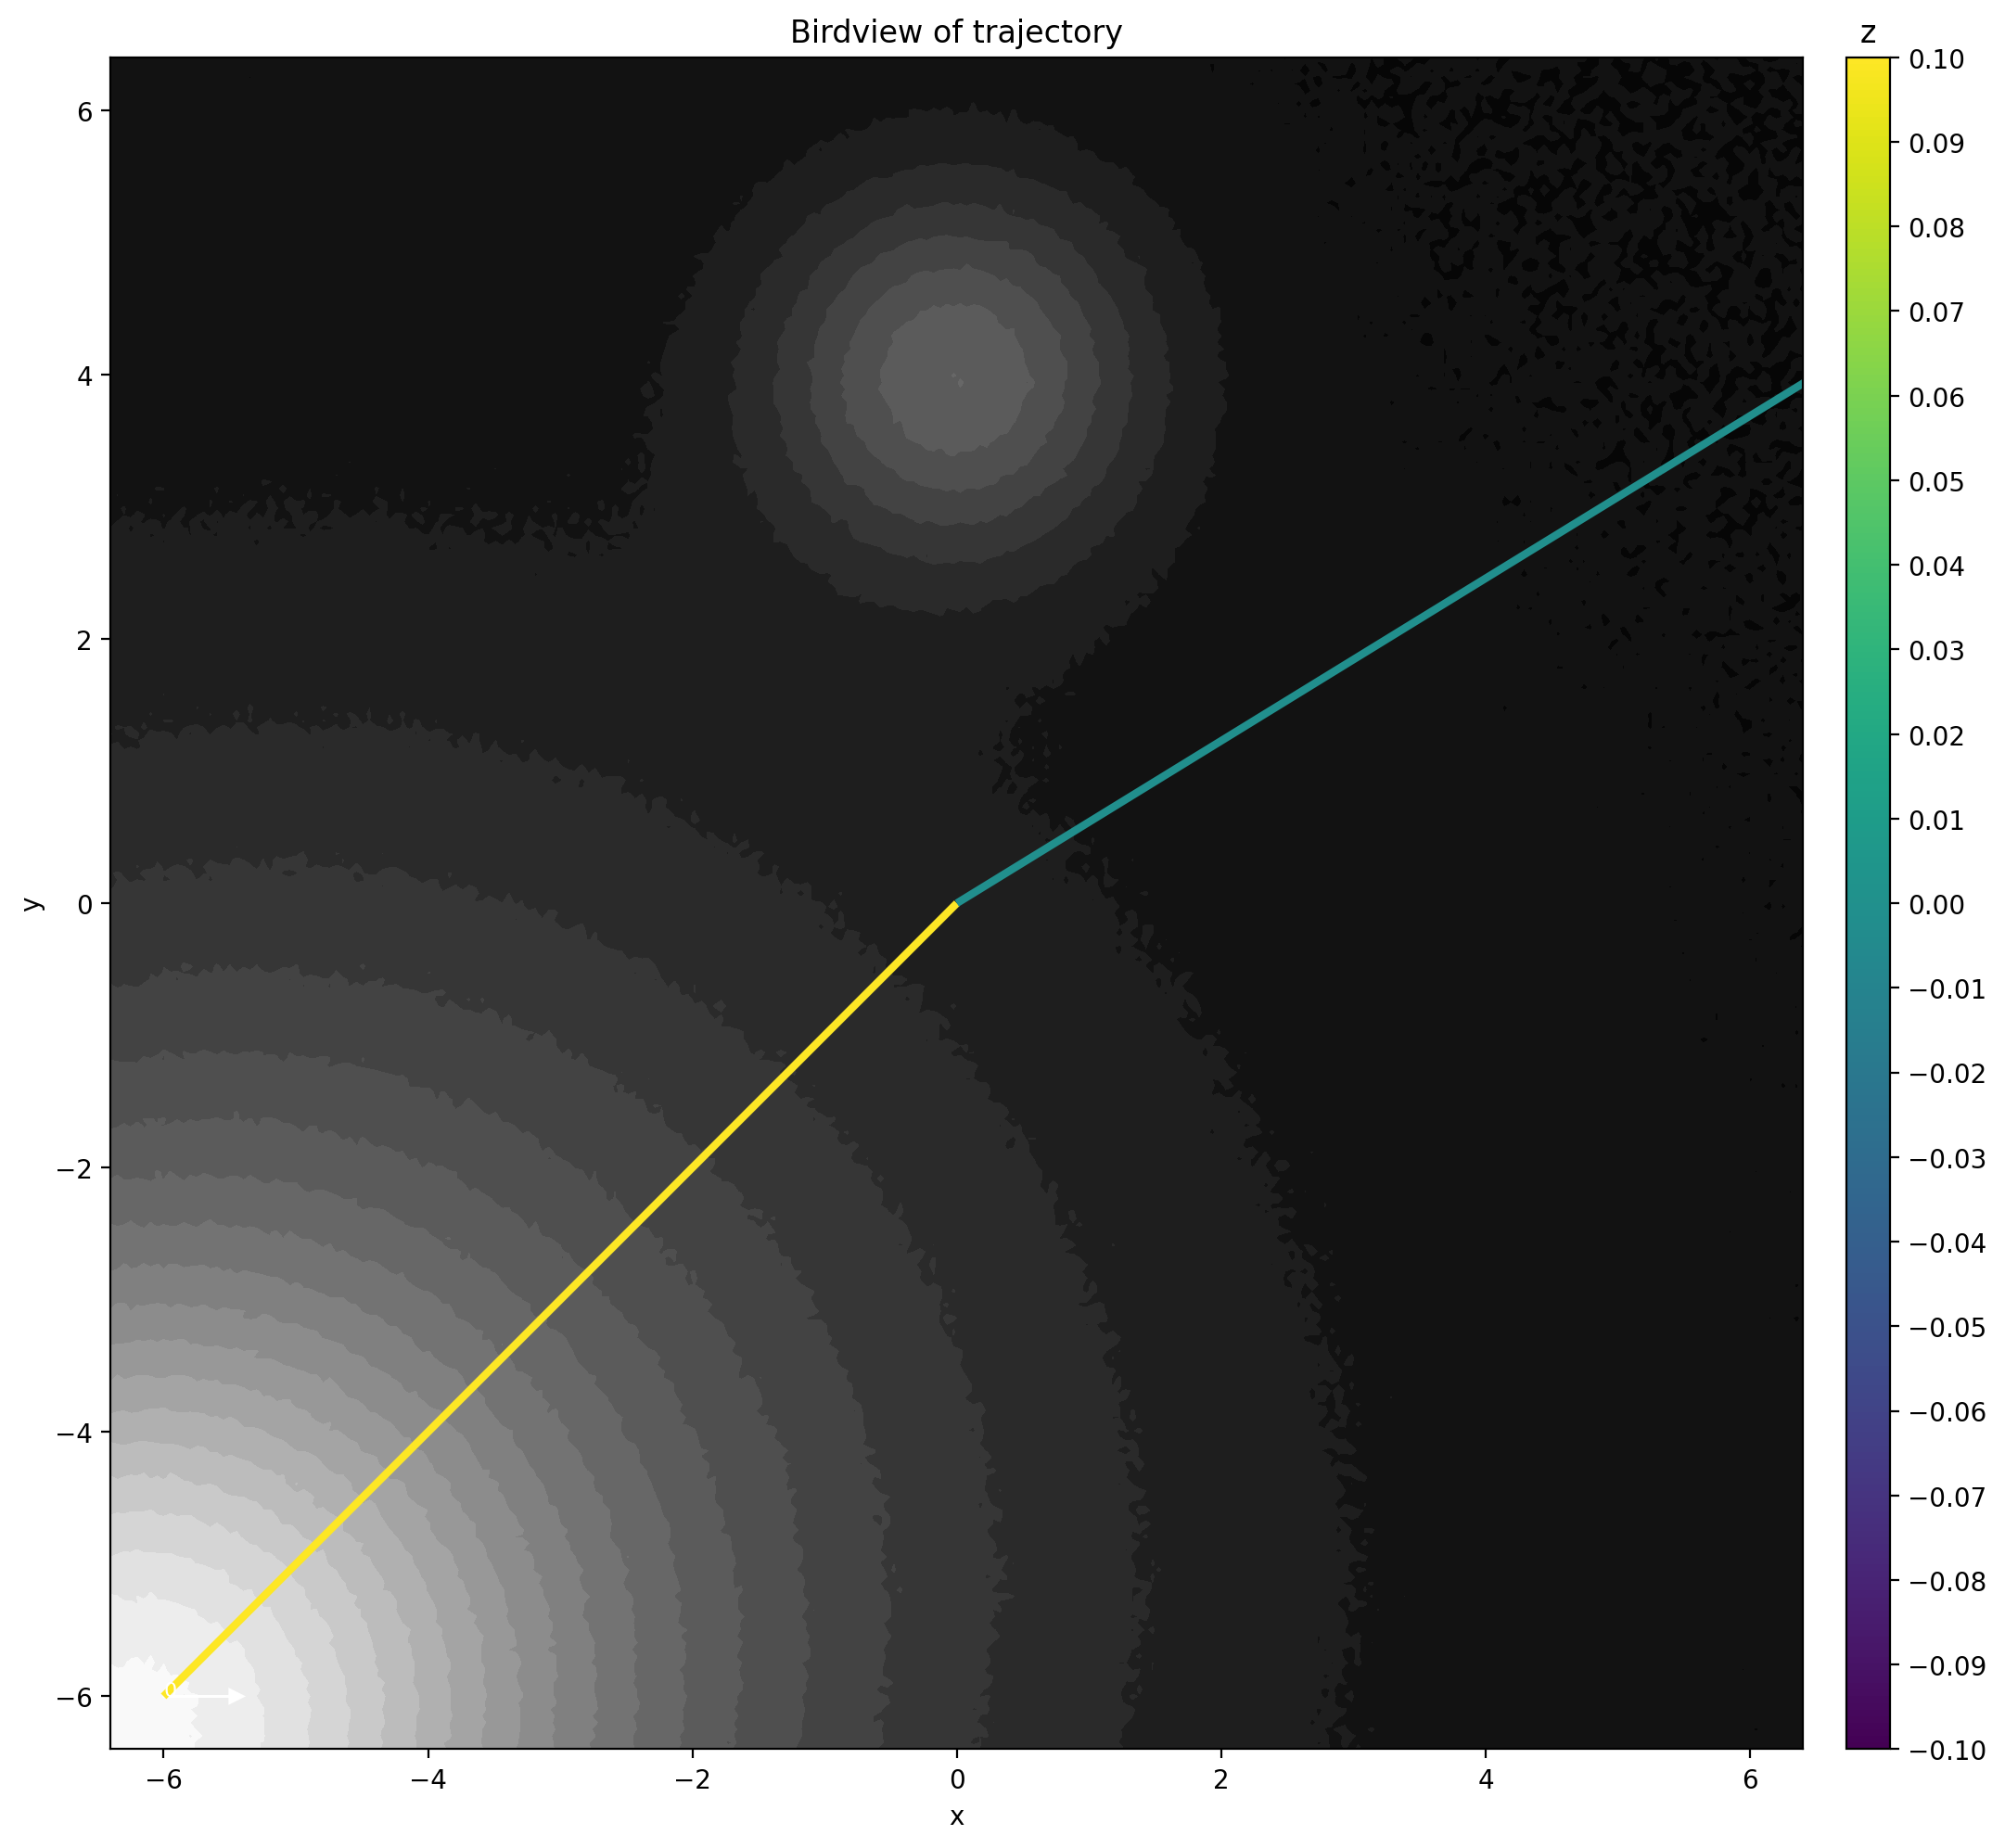

In [47]:
plot_birdview_trajectory(world_config, states, iter_step=40)

In [27]:
ROBOT_IDX = 0

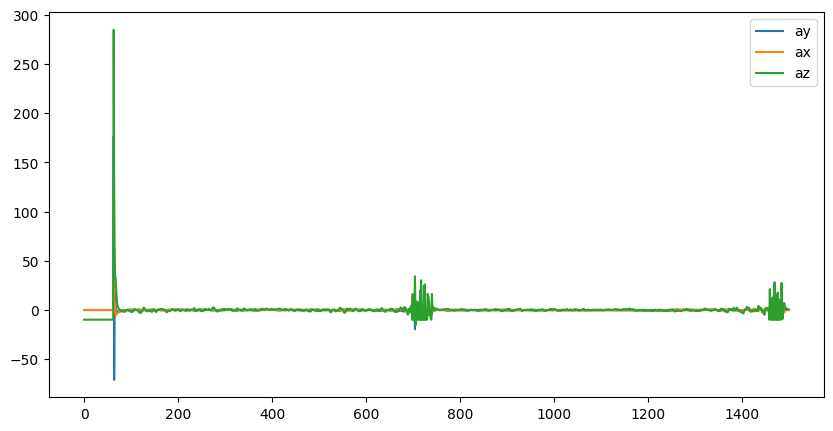

In [28]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(ay, label='ay')
plt.plot(ax, label='ax')
plt.plot(az, label='az')
plt.legend()

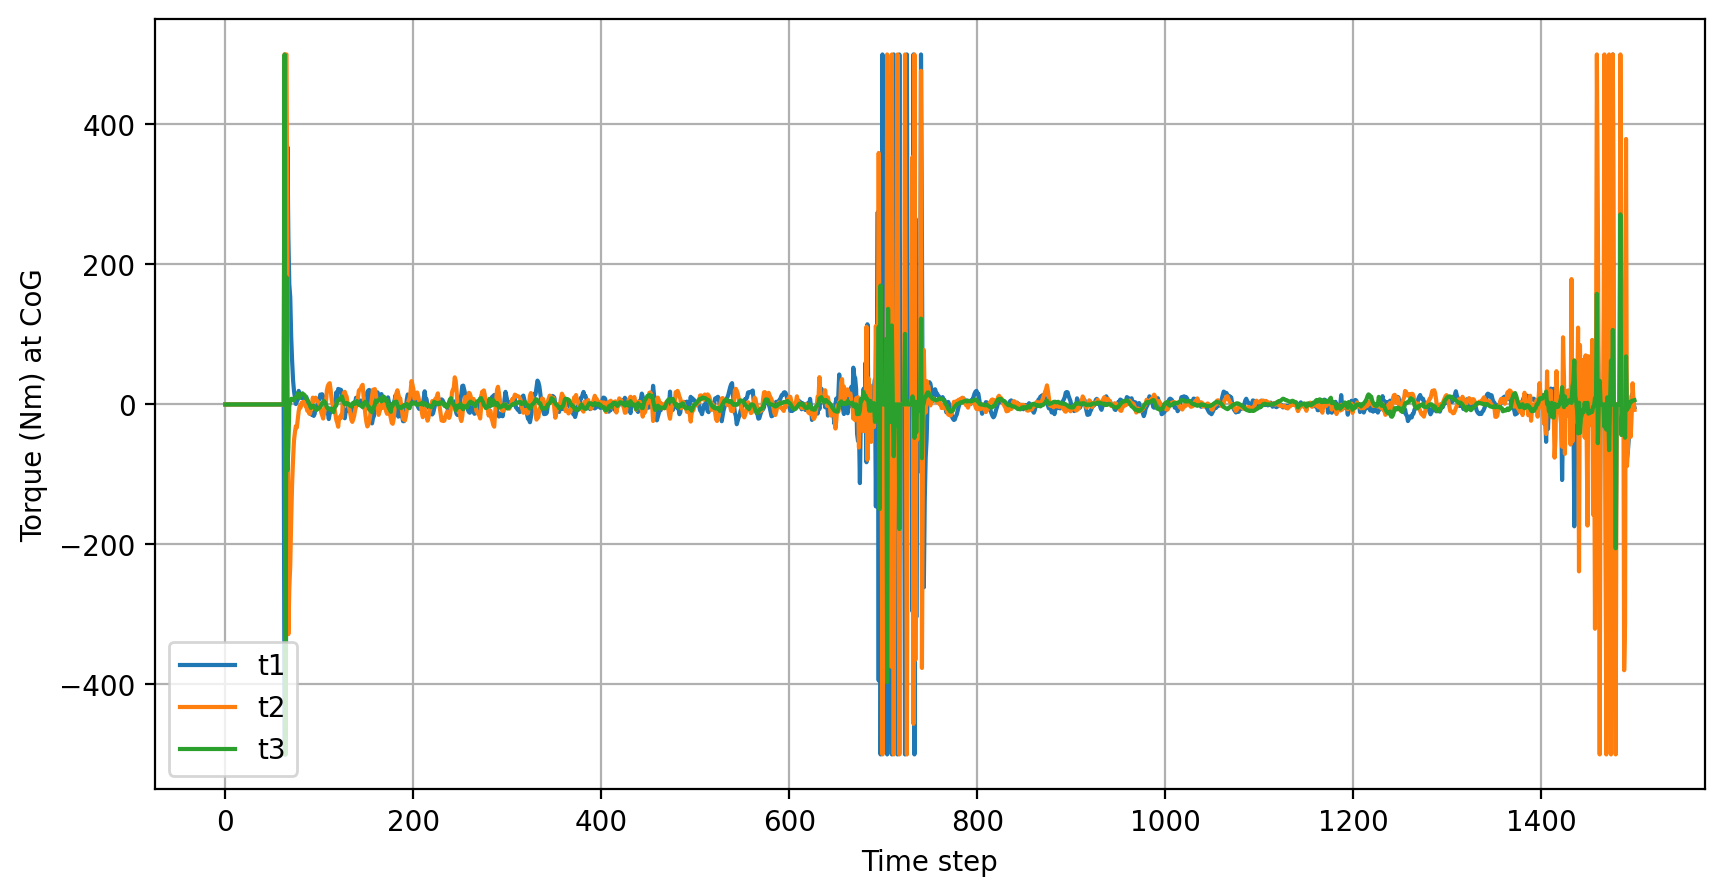

In [29]:
# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T.cpu().numpy()
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(t1, label='t1')
plt.plot(t2, label='t2')
plt.plot(t3, label='t3')
plt.grid()
plt.xlabel('Time step')
plt.ylabel('Torque (Nm) at CoG')
plt.legend()

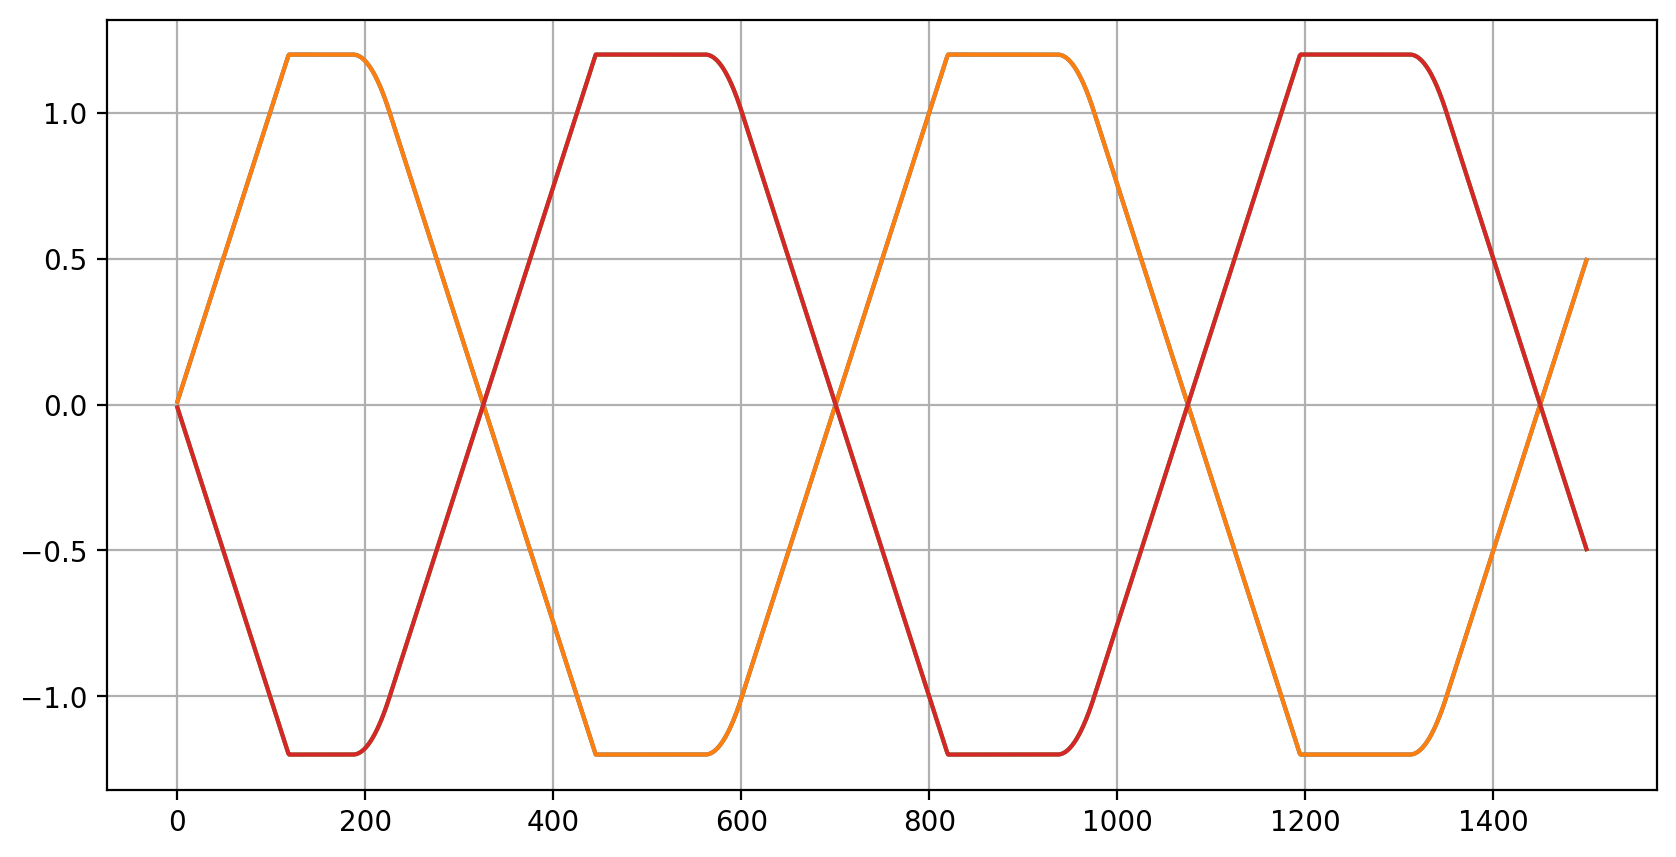

In [30]:
# Joint angles
plt.figure(figsize=(10, 5), dpi=200)
theta1, theta2, theta3, theta4 = states_vec.thetas[:, ROBOT_IDX].T.cpu().numpy()
plt.plot(theta1, label='theta1')
plt.plot(theta2, label='theta2')
plt.plot(theta3, label='theta3')
plt.plot(theta4, label='theta4')
plt.grid()

In [32]:
plot_3d_trajectory(world_config, states, auxs)

In [33]:
from flipper_training.vis.animator import animate_trajectory

In [34]:
animate_trajectory(world_config, physics_config, states, auxs, 0)

2025-01-01 17:15:57.195 Python[99836:5952348] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-01 17:15:57.195 Python[99836:5952348] +[IMKInputSession subclass]: chose IMKInputSession_Modern
